<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/Pipetting_protocol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from typing import List
from warnings import warn
from numbers import Real
from enum import Enum
from collections import OrderedDict 
import datetime as tm
from itertools import combinations 
#All volumes are in ul
#All concentrations are in uM

path='/content/drive/My Drive/Thesis'

protocol=""
to_match=4
%pprint
%precision 2

Pretty printing has been turned ON


'%.2f'

#protocol

##Classes

In [2]:
class Location(object):
  def __init__(self,name,location):
    self.name=name
    self.location=location
  def __str__():
    return self.name
  def __repr__():
    return self.name

unbound=Location('unbound location',None)

class Solution(object):
  def __init__(self,name:str,location:Location=None,viscous=False,info:str=None):
    self.name=name
    self.location=location
    self.viscous=viscous
    self.info=info
  def __str__(self):
    return self.name
  def __repr__(self):
    return self.name
  def __hash__(self):
    return str.__hash__(self.name)

global water 
water = Solution('water')

class Material(object):
  def __init__(self,name:str,material_type:str,stock_concentration:float,solution=water,buffer_info=None,location:Location=None,viscous=False,info:str=None):
    self.material_type=material_type 
    self.name=name
    self.viscous=viscous
    self.info=info
    self.location=location
    if material_type=='element' or material_type=='buffer':
      self.stock_concentration=stock_concentration
      #self.ratio=sample_concentration/stock_concentration #dilution ratio from stock to the final sample.
      if material_type=='element':
        self.buffer_info=buffer_info
        #if isinstance(self.buffer_info,BufferInfo): self.buffer_info=[buffer_info]
        self.solution=solution
  def __str__(self):
    return self.name
  def __repr__(self):
    return self.name

  def __add__(self,other):
    sum=Material(self.name,self.material_type,1,self.viscous)
    sum.name=f'{self.name}-{other.name}'
    sum.material_type='mixed'
    sum.viscous=self.viscous or other.viscous
    sum.info=self.info + other.info
    return sum

  def concentraionToVolume(self,final_concentration,final_volume):
    #c1.v1=c2.v2
    v1=final_concentration*final_volume/(self.stock_concentration)
    return v1


def concentraionToVolume(material,final_concentration,final_volume):
  #c1.v1=c2.v2
  v1=final_concentration*final_volume/(material.stock_concentration)
  return v1


class BufferInfo(object):
  def __init__(self,buffer:Material,buffer_final_concentration):
    self.buffer=buffer
    self.buffer_final_concentration=buffer_final_concentration
    self.buffer_initial_concentration=buffer.stock_concentration
    self.ratio=self.buffer_final_concentration/self.buffer_initial_concentration
  def __add__(self,buffer_info2):
    if not (isinstance(buffer_info2,BufferInfo) or isinstance(buffer_info2,list)): 
      raise TypeError('Only objects of type BufferInfo can be added together')
    if not isinstance(buffer_info2,list): buffer_info2=[buffer_info2]
    return removeDuplicate(buffer_info2+[self])
  def __radd__(self,buffer_info2):
    if not (isinstance(buffer_info2,BufferInfo) or isinstance(buffer_info2,list)): 
      raise TypeError('Only objects of type BufferInfo can be added together')
    if not isinstance(buffer_info2,list): buffer_info2=[buffer_info2]
    return removeDuplicate(buffer_info2+[self])
  def __eq__(self,other):
    for attr in self.__dict__:
      if getattr(self,attr)!=getattr(other,attr): return False
      return True
  def __hash__(self):
    return str.__hash__(self.buffer.name+str(self.buffer_final_concentration))

class PipettingComponent(object):
  def __init__(self,material:Material,volume:float):
    self.material=material
    self.volume=volume
  def __mul__(self,other):
    if not isinstance(other,Real): raise TypeError
    return PipettingComponent(self.material,self.volume*other)
  def __rmul__(self,other):
    if not isinstance(other,Real): raise TypeError
    return PipettingComponent(self.material,self.volume*other)
  def __add__(self,other):
    if not isinstance(other,PipettingComponent): raise TypeError
    volume=self.volume+other.volume
    if self.name==other.name:
      material=self.material
      addToProtocol('****this****')
    else:
      material=Material(self.name+other.name,self.ratio+other.ratio,viscous=self.viscous or other.viscous)
    return PipettingComponent(material,volume)
  def __radd__(self,other):
    if not isinstance(other,PipettingComponent): raise TypeError
    volume=self.volume+other.volume
    if self.name==other.name:
      material=self.material
    else:
      material=Material(self.name+other.name,self.ratio+other.ratio,viscous=self.viscous or other.viscous)
    return PipettingComponent(material,volume)
  def __repr__(self):
    return f"{self.volume:.2f}:{self.material.name}"
  def __str__(self):
    return f"{self.volume:.2f}:{self.material.name}"

def sumUpDuplicatePipettingComponents(l):
  for i in range(len(l)):
    sum=l[i]
    for j in range(len(l)-1,i,-1):
      print(l[i],l[j],sum)
      if l[i].material.name==l[j].material.name: 
        sum+=l[j] 
        del(l[j])
    l[i]=sum
  return l

class DilutionProfile_single(object):
  def __init__(self,sample_to_scan_ratio,total_volume,material:Material,dilution_coefficient,highest_concentration):
    self.total_volume=total_volume
    self.material=material
    self.dilution_coefficient=dilution_coefficient
    self.first_well_concentration=highest_concentration
    self.highest_concentration=highest_concentration
    self.buffer_info=material.buffer_info
    

    self.transfer_volume=self.dilution_coefficient * self.total_volume /(1-self.dilution_coefficient)

    self.first_well_volume=self.transfer_volume+self.total_volume
    self.dilution_stock=self.first_well_concentration*sample_to_scan_ratio
    self.element_volume=self.dilution_stock*self.first_well_volume/material.stock_concentration
    self.first_well_buffer_volume=concentraionToVolume(self.buffer_info.buffer,self.buffer_info.buffer_final_concentration,self.first_well_volume) if self.buffer_info else 0
    self.first_well_water_volume=self.first_well_volume - self.element_volume - self.first_well_buffer_volume

    self.next_wells_buffer_volume= concentraionToVolume(self.buffer_info.buffer,self.buffer_info.buffer_final_concentration,self.total_volume) if self.buffer_info else 0
    self.next_wells_solution_volume= self.element_volume*self.transfer_volume/self.first_well_volume if material.solution.name!='water' else 0
    self.next_wells_water_volume=self.total_volume - self.next_wells_solution_volume - self.next_wells_buffer_volume

    
    self.buffer_pipetting_component_first_well=[PipettingComponent(self.buffer_info.buffer,self.first_well_buffer_volume)] if self.buffer_info else []
    self.buffer_pipetting_component_next_wells=[PipettingComponent(self.buffer_info.buffer,self.next_wells_buffer_volume)] if self.buffer_info else []

    self.solution_pipetting_component=[PipettingComponent(material.solution,self.next_wells_solution_volume)] if material.solution.name!='water' else []

##Basic Functions

In [3]:
protocol=""

def addToProtocol(*lines):
  global protocol
  for line in lines:
    protocol+=line+'\n'

def transfer(material:Material,volume,destination:Location,mix_after=(),viscous=False,multiply=1,return_str=False):
  volume=volume*multiply
  volume=round(volume,2)
  message=f'transfer {volume}ul {material} {destination} {"**mix: "+str(mix_after)+"**" if mix_after else ""}'
  if return_str: return message+'\n'
  addToProtocol(message)

def distribute(volume:float,source:Material,destinations,viscous=False):
  volume=round(volume,2)
  addToProtocol(f'Distribute {volume}ul {source} to {destinations}')

def dilution_serie(sample_to_scan_ratio,total_volume,number_of_dilution_wells:int,dilution_coefficient,materials:List[Material],highest_concentrations:List[float],location:Location=None,mark_as=""):
    addToProtocol(f'\n~~Dilution Serie {materials} ~~')
    dilution_profile = None
    n_matrials = len(materials)
    add_elements_to_first_well = ''
    
    for i,material in enumerate(materials):
      dilution_profile_i = DilutionProfile_single(sample_to_scan_ratio,total_volume/n_matrials,material,dilution_coefficient,highest_concentrations[i])
      add_elements_to_first_well += transfer(material,dilution_profile_i.element_volume,'first well',return_str=True)

      if i==0: dilution_profile=dilution_profile_i
      else:
        #This is wrong because buffer combination ends up with less concentration. You should mix dilution profiles in initiation..
        dilution_profile.transfer_volume += dilution_profile_i.transfer_volume
        dilution_profile.first_well_water_volume += dilution_profile_i.first_well_water_volume
        dilution_profile.next_wells_water_volume += dilution_profile_i.next_wells_water_volume
        dilution_profile.buffer_pipetting_component_first_well = sumUpDuplicatePipettingComponents(dilution_profile.buffer_pipetting_component_first_well+[dilution_profile_i.buffer_pipetting_component_first_well])
        dilution_profile.buffer_pipetting_component_next_wells = sumUpDuplicatePipettingComponents(dilution_profile.buffer_pipetting_component_next_wells+[dilution_profile_i.buffer_pipetting_component_next_wells])
        dilution_profile.solution_pipetting_component = sumUpDuplicatePipettingComponents(dilution_profile.solution_pipetting_component+[dilution_profile_i.solution_pipetting_component])

    #add to protocol
    next_wells_buffer_solution = dilution_profile.buffer_pipetting_component_next_wells + dilution_profile.solution_pipetting_component
    next_wells=PipettingComponent(water,dilution_profile.next_wells_water_volume)

    if next_wells_buffer_solution:
      times=(number_of_dilution_wells-1)*1.2
      addToProtocol(f'In a larger eppi Mix {dilution_profile.next_wells_water_volume:.2f} Water')
      for component in next_wells_buffer_solution: 
        addToProtocol(f'Mix {component*times}')
        next_wells.volume += component.volume *times
      next_wells.material='Mixture'
    
    distribute(next_wells.volume,next_wells.material,'all wells except first well')
    
    transfer(water,dilution_profile.first_well_water_volume,'first well')
    for component in dilution_profile.buffer_pipetting_component_first_well:
      transfer(component.material,component.volume,'first well')
      addToProtocol('Mix')
    addToProtocol(add_elements_to_first_well,f'dilution series with {dilution_profile.transfer_volume:.2f} transfer volume\n~~~~~~~')


##Function to produce protocol

In [35]:
def Make_protocol(sample_volume,sample_composition,scanning_volume,size,scanning_profile,grid_profile_keys,title:str):
  '''
  size=8 means an 8 * 8 grid
  '''
  global protocol
  protocol = ""
  block_size = size/2
  n_wells = size*size
  n_wells_in_block = block_size*block_size
  n_scanning_elements=len(scanning_profile)

  ##dilution series
  times = n_wells/block_size * 1.2
  for material in scanning_profile:
    dilution_serie(sample_volume/scanning_volume, scanning_volume*times , block_size,scanning_profile[material][1],[material],[scanning_profile[material][0]])

  ##Mastermix
  addToProtocol('Master Mix:')
  times = n_wells * 1.2
  mastermix_elements = set(sample_composition)-set(scanning_profile)
  mastermix_volume_each_sample = sample_volume - ( n_scanning_elements* scanning_volume)
  sum_volume = 0

  for element in mastermix_elements:
    volume = concentraionToVolume(element,sample_composition[element],sample_volume) * times
    sum_volume += concentraionToVolume(element,sample_composition[element],sample_volume)
    addToProtocol(f'Mix {volume:.2f}ul {element} in Mastermix')
  water_in_mastermix= (mastermix_volume_each_sample - sum_volume) * times
  addToProtocol(f'Mix {water_in_mastermix:.2f}ul water in Mastermix')

  addToProtocol(f'Distribute {mastermix_volume_each_sample*times/block_size:.2f} Mastermix in {block_size} strips')

  addToProtocol(f'\nEach well: {sample_volume-(n_scanning_elements*scanning_volume)}ul Mastermix and {scanning_volume}ul each scanning element')

  addToProtocol('\n',str(grid_profile_keys))

  print(protocol)
  with open(f'{path}/protocol-{title}-{tm.datetime.now()}.txt','w+') as file:
    file.write(f'{tm.datetime.now()}\n'+protocol)


##Materials, Sample info and protocol

In [7]:
sample_volume=20

dfhbi=Material('DFHBI','element',400,solution=water)
neb=Material('NEB-buffer','buffer',10)
#rnase_inhibitor=Material('Rnase_inhibitor','element',40,1)
t3r5_solution=Solution('T3R5_solution',viscous=True)
t3r5_buffer_info=BufferInfo(neb,1)
t3r5=Material('T3R5','element',2055,solution=t3r5_solution,buffer_info=t3r5_buffer_info,viscous=True)
template=Material('template','element',500,solution=water)
mgcl2=Material('MgCl2','element',2000,solution=water)
rntp=Material('rNTP-mix','element',25,solution=water)

sample_composition={dfhbi:40,neb:1,t3r5:100,template:50,mgcl2:20,rntp:25}
scanning_profile=OrderedDict({t3r5:(100,0.5),
                               template:(50,0.5),
                               mgcl2:(20,0.5),
                               rntp:(5,0.5)})

grid_profile_keys=[[1,2,1,2],[1,2,2,-1],[1,2,-1,-2],[1,2,-2,1]]

Make_protocol(sample_volume,sample_composition,4,8,scanning_profile,grid_profile_keys,title='IVT-iter1')



~~Dilution Serie [T3R5] ~~
In a larger eppi Mix 50.43 Water
Mix 27.65:NEB-buffer
Mix 67.27:T3R5_solution
Distribute 145.35ul Mixture to all wells except first well
transfer 100.87ul water first well 
transfer 15.36ul NEB-buffer first well 
Mix
transfer 37.37ul T3R5 first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [template] ~~
Distribute 76.8ul water to all wells except first well
transfer 76.8ul water first well 
transfer 76.8ul template first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [MgCl2] ~~
Distribute 76.8ul water to all wells except first well
transfer 145.92ul water first well 
transfer 7.68ul MgCl2 first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [rNTP-mix] ~~
Distribute 76.8ul water to all wells except first well
transfer 0.0ul water first well 
transfer 153.6ul rNTP-mix first well 

dilution series with 76.80 transfer volume
~~~~~~~
Master Mix:
Mix 153.6ul DFHBI in Mastermix


27.10.20

In [36]:
sample_volume=20

dfhbi=Material('DFHBI','element',4000,solution=water)

tris_dtt=Material('Tris-DTT Buffer','buffer',10)
#rnase_inhibitor=Material('Rnase_inhibitor','element',40,1)
t7_solution=Solution('T7_solution',viscous=True)
t7_buffer_info_1=BufferInfo(tris_dtt,1)
t7=Material('T7','element',12311,solution=t7_solution,buffer_info=t7_buffer_info_1,viscous=True)

template=Material('template','element',500,solution=water)
mgcl2=Material('MgCl2','element',2000,solution=water)
rntp=Material('rNTP-mix','element',25,solution=water)
spermidine=Material('Spermidine','element',1000,solution=water)

sample_composition={dfhbi:40,tris_dtt:1,spermidine:5,t7:100,template:50,mgcl2:40,rntp:5}
scanning_profile=OrderedDict({spermidine:(5,0.5),
                               template:(50,0.5),
                               mgcl2:(40,0.5),
                               rntp:(5,0.5)})

grid_profile_keys=[[1,2,1,2],[1,2,2,-1],[1,2,-1,-2],[1,2,-2,1]]

Make_protocol(sample_volume,sample_composition,4,8,scanning_profile,grid_profile_keys,title='IVT-iter1')



~~Dilution Serie [Spermidine] ~~
Distribute 76.8ul water to all wells except first well
transfer 149.76ul water first well 
transfer 3.84ul Spermidine first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [template] ~~
Distribute 76.8ul water to all wells except first well
transfer 76.8ul water first well 
transfer 76.8ul template first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [MgCl2] ~~
Distribute 76.8ul water to all wells except first well
transfer 138.24ul water first well 
transfer 15.36ul MgCl2 first well 

dilution series with 76.80 transfer volume
~~~~~~~

~~Dilution Serie [rNTP-mix] ~~
Distribute 76.8ul water to all wells except first well
transfer 0.0ul water first well 
transfer 153.6ul rNTP-mix first well 

dilution series with 76.80 transfer volume
~~~~~~~
Master Mix:
Mix 15.36ul DFHBI in Mastermix
Mix 153.60ul Tris-DTT Buffer in Mastermix
Mix 12.48ul T7 in Mastermix
Mix 125.76ul water in Mastermix
Distribute 7

In [32]:
scanning_profile=OrderedDict({spermidine:(5,0.5),
                               template:(50,0.5),
                               mgcl2:(40,0.5),
                               rntp:(5,0.5)})

grid_profile_keys1=[[1,2,1,2],[1,2,2,-1],[1,2,-1,-2],[1,2,-2,1]]
grid_profile_keys2=[[1,1,2,2],[1,2,2,-1],[1,-2,2,1],[1,-1,2,-2]]
grid_profile_keys=grid_profile_keys1+grid_profile_keys2
Make_protocol(sample_volume,sample_composition,8,16,scanning_profile,grid_profile_keys,title='IVT-iter1-double')


~~Dilution Serie [Spermidine] ~~
Distribute 307.2ul water to all wells except first well
transfer 606.72ul water first well 
transfer 7.68ul Spermidine first well 

dilution series with 307.20 transfer volume
~~~~~~~

~~Dilution Serie [template] ~~
Distribute 307.2ul water to all wells except first well
transfer 460.8ul water first well 
transfer 153.6ul template first well 

dilution series with 307.20 transfer volume
~~~~~~~

~~Dilution Serie [MgCl2] ~~
Distribute 307.2ul water to all wells except first well
transfer 583.68ul water first well 
transfer 30.72ul MgCl2 first well 

dilution series with 307.20 transfer volume
~~~~~~~

~~Dilution Serie [rNTP-mix] ~~
Distribute 307.2ul water to all wells except first well
transfer 307.2ul water first well 
transfer 307.2ul rNTP-mix first well 

dilution series with 307.20 transfer volume
~~~~~~~
Master Mix:
Mix 614.40ul Tris-DTT Buffer in Mastermix
Mix 49.91ul T7 in Mastermix
Mix 61.44ul DFHBI in Mastermix
Mix -4412.15ul water in Mastermi

#distribution

##Protocol to inputs

In [9]:
def fill_a_block(direction,initial_concentration,dilution_coefficient,n_wells_in_block=4,real_concentrations=False):
  if real_concentrations:
    diluted_concentraitions=dilution_concentraitions(initial_concentration,dilution_coefficient,n_wells_in_block)
  else:
    diluted_concentraitions=dilution_concentraitions(1,dilution_coefficient,n_wells_in_block) #fix for next iteration

  if direction<0:
    diluted_concentraitions.reverse()
  direction=abs(direction)
  block=np.stack([diluted_concentraitions]*n_wells_in_block,axis=direction-1)
  return block


def dilution_concentraitions(initial_concentration,dilution_coefficient,number_of_wells=4):
  concentrations=[]
  c=initial_concentration
  for i in range(number_of_wells):
    concentrations.append(c)
    c=c*dilution_coefficient
  return concentrations

def build_grid_out_of_blocks(block1,block2,block3,block4):
  l1=np.concatenate((block1,block2),axis=1)
  l2=np.concatenate((block3,block4),axis=1)
  return np.concatenate((l1,l2),axis=0)
  #this only works with 4 blocks. I don't know how we want to represent more number of blocks. Update in future cases.

def grid_profile_to_concentration(scanning_profile,grid_profile_keys,real_concentrations=False):
  number_of_elements=len(scanning_profile)
  number_of_blocks=len(grid_profile_keys)
  concentrations=OrderedDict({})
  for i,material in enumerate(scanning_profile):
    blocks=[]
    for b in range (number_of_blocks):
      direction=grid_profile_keys[b][i]
      block=fill_a_block(direction,scanning_profile[material][0],scanning_profile[material][1],real_concentrations=real_concentrations)
      blocks.append(block)
    concentrations[material]=build_grid_out_of_blocks(blocks[0],blocks[1],blocks[2],blocks[3])

  return concentrations

scanning_concentrations=grid_profile_to_concentration(scanning_profile,grid_profile_keys)
for element in scanning_concentrations:
  print(element,'\n',scanning_concentrations[element])
  print(scanning_concentrations[element].shape)
  scanning_concentrations[element]=scanning_concentrations[element].flatten()
  print(scanning_concentrations[element].shape)

T3R5 
 [[1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]
 [1.   0.5  0.25 0.12 1.   0.5  0.25 0.12]]
(8, 8)
(64,)
template 
 [[1.   1.   1.   1.   1.   1.   1.   1.  ]
 [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12]
 [1.   1.   1.   1.   1.   1.   1.   1.  ]
 [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
 [0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12]]
(8, 8)
(64,)
MgCl2 
 [[1.   0.5  0.25 0.12 1.   1.   1.   1.  ]
 [1.   0.5  0.25 0.12 0.5  0.5  0.5  0.5 ]
 [1.   0.5  0.25 0.12 0.25 0.25 0.25 0.25]
 [1.   0.5  0.25 0.12 0.12 0.12 0.12 0.12]
 [0.12 0.25 0.5  1.   0.12 0.12 0.12 0.12]
 [0.12 0.25 0.5  1.   0.25 0.25 0.25 0.25]


##checking the distribution

In [16]:
def plot_3d_distribution (xs,ys,zs,name,xlabel='x',ylabel='y',zlabel='z'):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs, ys, zs, zdir='z')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  plt.show()
  plt.savefig(f'{path}/distribution-{name}.jpg')
  plt.clf()

def plot_2d_distribution (x,y,name,xlabel='x',ylabel='y'):
  #fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=100)
  fig, ax = plt.subplots()
  plt.scatter(x,y,alpha=0.2)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  plt.show()
  plt.savefig(f'{path}/distribution-{name}.jpg')
  plt.clf()

###3D

(T3R5, template, MgCl2)
(64,) (64,) (64,)


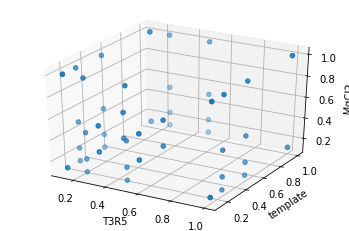

(T3R5, template, rNTP-mix)
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

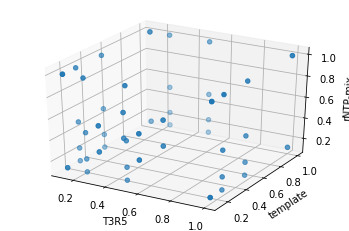

(T3R5, MgCl2, rNTP-mix)
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

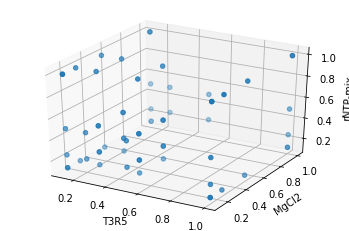

(template, MgCl2, rNTP-mix)
(64,) (64,) (64,)


<Figure size 432x288 with 0 Axes>

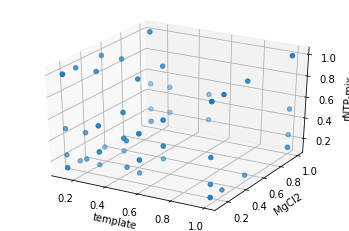

<Figure size 432x288 with 0 Axes>

In [17]:

comb=combinations(scanning_profile,3)
for names in comb:
  print(names)
  xlabel,ylabel,zlabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  zs=scanning_concentrations[zlabel]
  print(xs.shape,ys.shape,zs.shape)
  plot_3d_distribution(xs,ys,zs,str(names),xlabel,ylabel,zlabel)

###2D

(T3R5, template)


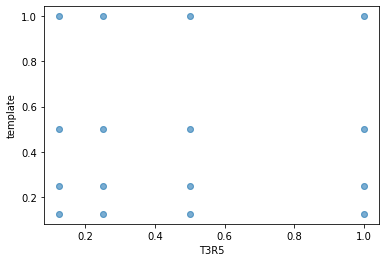

(T3R5, MgCl2)


<Figure size 432x288 with 0 Axes>

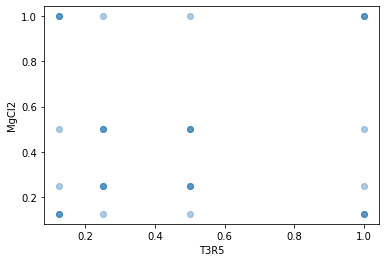

(T3R5, rNTP-mix)


<Figure size 432x288 with 0 Axes>

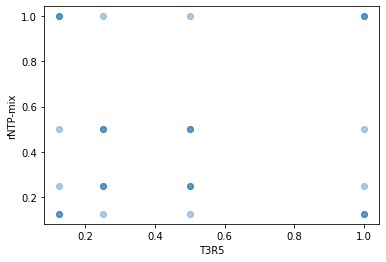

(template, MgCl2)


<Figure size 432x288 with 0 Axes>

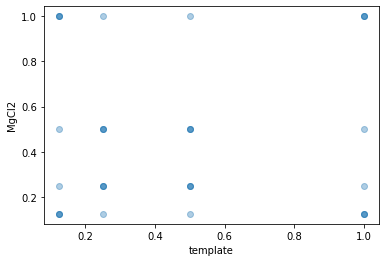

(template, rNTP-mix)


<Figure size 432x288 with 0 Axes>

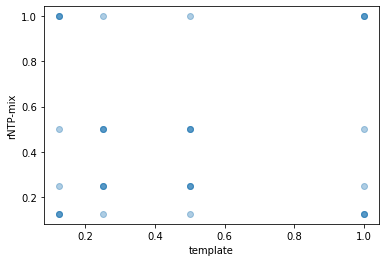

(MgCl2, rNTP-mix)


<Figure size 432x288 with 0 Axes>

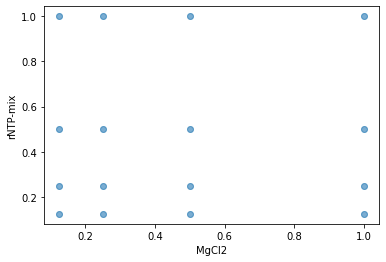

<Figure size 432x288 with 0 Axes>

In [18]:
comb=combinations(scanning_profile,2)
for names in comb:
  print(names)
  xlabel,ylabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  plot_2d_distribution(xs,ys,str(names),xlabel,ylabel)